In [1]:
# Installations
# pip install -q -U google-generativeai
# pip install pandas
# pip install seaborn
# pip install nltk
# pip install scikit-learn

In [2]:
# Importing Dependencies
import google.generativeai as genai
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import traceback
import nltk
from PIL import Image
import time

start = time.time()

/Users/bhavishyapandit/VSCProjects/google-ai-hackathon24/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# User input: Getting table description
# table_description = input('Table/Data description')
table_description = 'Data consists of fatal police shooting. It has name of the criminal, date, manner of death etc.'

### Reading Data

In [4]:
# Fetching credentials
f = open('credentials.json', 'r')
creds = json.load(f)
gemini_token = creds['gemini_api']

df = pd.read_csv('data/police_shooting/fatal_police_shooting.csv')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(4478, 15)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,age_categories
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,Senior Citizen
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,Adut
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,Youth
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,Youth
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,Adut


In [6]:
def generate_response(prompt, temperature, safety_setting):
    generation_config = {
      "temperature": temperature,
      "top_p": 1,
      "top_k": 1,
    }
    safety_settings = [
        {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": safety_setting
        },
        {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": safety_setting
        },
        {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": safety_setting
        },
        {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": safety_setting
        },
    ]
    genai.configure(api_key=gemini_token)
    model = genai.GenerativeModel('gemini-pro')
    model = genai.GenerativeModel(model_name="gemini-1.0-pro",
                                    generation_config=generation_config,
                                    safety_settings=safety_settings)
    convo = model.start_chat(history=[])
    convo.send_message(prompt)
    return re.sub(r"\*\*([^*]+)\*\*", r"\1", convo.last.text)

### Creating Data Dictionary

In [7]:
data_dict = {}
create_data_dict = f'''Table description: {table_description}
Columns: {df.columns}
Data types: {df.dtypes}

Instruction:
1. Based on the above mentioned details create a data dictionary which a small description of table, each column and the data type of each column.
2. Don't generate anything else. Be concrete and concise in your response
3. Give the output in the expected format of a dictionary only!
'''
output = '''
Expected Output -> 
data_dict={
'tbl_description': 'description of table', 
'columns': {
            'Name of the column 1': {'col_description':'description of column 1', 'data_type':'Data Type of the column 1'},
            'Name of the column 2': {'col_description':'description of column 2', 'data_type':'Data Type of the column 2'},
            'Name of the column 3': {'col_description':'description of column 3', 'data_type':'Data Type of the column 3'}
        }
}'''

create_data_dict+=output

response = generate_response(create_data_dict, 0, 'BLOCK_NONE')
print(response)
exec(response)

data_dict={
'tbl_description': 'Data consists of fatal police shooting. It has name of the criminal, date, manner of death etc.', 
'columns': {
            'id': {'col_description':'Unique identifier for each row', 'data_type':'int64'},
            'name': {'col_description':'Name of the criminal', 'data_type':'object'},
            'date': {'col_description':'Date of the shooting', 'data_type':'object'},
            'manner_of_death': {'col_description':'Manner of death', 'data_type':'object'},
            'armed': {'col_description':'Whether the criminal was armed', 'data_type':'object'},
            'age': {'col_description':'Age of the criminal', 'data_type':'float64'},
            'gender': {'col_description':'Gender of the criminal', 'data_type':'object'},
            'race': {'col_description':'Race of the criminal', 'data_type':'object'},
            'city': {'col_description':'City where the shooting occurred', 'data_type':'object'},
            'state': {'col_description':'St

In [8]:
safety_setting = 'BLOCK_MEDIUM_AND_ABOVE'
temperature = 0
identify_threat_level = f'''

Role: You are Gemini

Action: Based on harm categories identify the level of threat as: LOW, MEDIUM or HIGH
Data: {df.head()}
Harm categories: HARM_CATEGORY_HARASSMENT, HARM_CATEGORY_SEXUALLY_EXPLICIT, HARM_CATEGORY_HATE_SPEECH, HARM_CATEGORY_DANGEROUS_CONTENT

Instructions:
1. Restrict your response to only LOW, MEDIUM or HIGH at all costs

Expected output format: LOW or HIGH etc.'''

threat_level = generate_response(identify_threat_level, temperature, 'BLOCK_NONE')

if threat_level=='HIGH':
    print('Taking user consent..')
    safety_setting = 'BLOCK_NONE'
print('Safety setting has been set to: ', safety_setting)

Taking user consent..
Safety setting has been set to:  BLOCK_NONE


### Analysis Recommendation

In [9]:
# # If user want's suggestions of different types of analysis
# prompt = f'''{table_description}\n Refer {data_dict['columns'].keys()} and tell me the different analysis that can be done from the available columns keeping the given use case in mind.
# Focus on Exploratory Data Analysis only. 

# Unique values in categorical column: {df.select_dtypes(include='object').nunique()}
# Unique values in numerical column: {df.select_dtypes(include='number').nunique()}

# Instructions:
# 1. Keep your response consise and concrete
# 2. Give your suggestions in bullet points
# 3. Mention the columns that will help in the completion of the respective analysis
# 4. Make the analysis rich by including as many important columns as possible. Don't include columns with no/very little variance.
# 5. Every new type of analysis in the response should be represented with ">>" at all costs
# 6. The analysis should be complex but at the same time either convey action items or actionable insights
# 7. Don't generate a column name by your own. Use only the columns: {data_dict['columns'].keys()}
# 8. Don't mention the columns in "" or ''.
# 9. Don't add anything else to your response, except for Analysis name and the relevant columns
# 10. Give the response in the expected format only.
# 11. The analysis should be suggested from the growth/impact to the business - perspective


# Expected output:
# >> Analysis 1
# - Columns: A, B, C etc.

# >> Analysis 2
# - Columns: A, C, E etc.
# etc.
# '''

# types_of_analysis = generate_response(prompt, 0.5)
# print(types_of_analysis)

In [10]:
# # User selects an analysis to perform
# list_of_analyses = types_of_analysis.split('>> ')[1:]
# my_analysis = list_of_analyses[0]
# my_analysis = my_analysis.replace('\n','')
# my_analysis

In [11]:
# If user wants to give his own analysis
my_analysis = '''For each gender how many people were shot belonging to age between 30 and 50.
                
                Always Include: Relevant numbers/figures associated with the analysis.
                '''

identify_colums = f'''Analysis: {my_analysis}
Remember: Almmost every analysis requires some kind of aggregation or grouping.
First 5 rows of Dataframe for your reference: {df.head()}

Instructions:
1. Based on the Analysis mentioned, Give the names of the relevant columns from {data_dict['columns']}
2. Don't generate any column of your own
3. If the analysis request is not direct then identify a logic from the given columns that would help you with the analysis.
4. Don't write anything else, just the column names.

Expected Output if relevant columns found:
Columns: A, C, E etc.
'''

column_names = generate_response(identify_colums, 0, safety_setting)
print(column_names)

Columns: age, gender


In [12]:
# columns to work on
# Find the index of "Columns:"
columns_index = column_names.find("Columns:")

# Extract the text after "Columns:"
columns_text = column_names[columns_index + len("Columns:"):].strip()

# Print the extracted text
columns = columns_text.split(', ')
columns

['age', 'gender']

In [13]:
data = df[columns]
data.head()
columns_intel = ''
for key, val in data_dict['columns'].items():
    if key in columns:
        columns_intel+=f'{key}: {val}\n'

print(columns_intel)

age: {'col_description': 'Age of the criminal', 'data_type': 'float64'}
gender: {'col_description': 'Gender of the criminal', 'data_type': 'object'}



In [14]:
template_check = f'''
Top 5 rows: {data.head()}
Data: {data.columns}

Based on the above details tell me what type of data is it?
Rules:
1. If consists text data then write 'Text'
2. Else 'Numeric'
3. Don't write anything else just respond whether it is 'Text' or 'Numeric'
'''

template_to_choose = generate_response(template_check, 0, safety_setting)
template_to_choose

'Numeric'

In [15]:
def drop_high_missing_columns(df, missing_threshold=25):
  """Drops columns in a pandas DataFrame that have more than the specified missing value threshold.

  Args:
      df (pd.DataFrame): The DataFrame to process.
      missing_threshold (float, optional): The threshold for the proportion of missing values in a column. Defaults to 0.1 (10%).

  Returns:
      pd.DataFrame: The DataFrame with columns exceeding the missing value threshold dropped.
  """

  # Calculate the percentage of missing values per column
  missing_vals = 100 * df.isnull().sum() / len(df)

  # Identify columns to drop
  cols_to_drop = missing_vals[missing_vals > missing_threshold].index

  # Drop the columns if any
  if len(cols_to_drop) > 0:
    return df.drop(cols_to_drop, axis=1)
  else:
    return df.copy()  # Return a copy to avoid modifying the original DataFrame

data = drop_high_missing_columns(data, missing_threshold=25)
data.head()

,age,gender
0,53.0,M
1,47.0,M
2,23.0,M
3,32.0,M
4,39.0,M


### Preprocessing Data

In [16]:
# Prompt Template for numeric data - 
if template_to_choose=='Numeric':
    preprocessing_template = '''
    > Data Imputation:-
        When to use: Data imputation is used to fill in missing values (e.g. Null, None or NaN) in the dataset. Impute mode for categorical and mean/median otherwise.
        For what type of data: This step is applicable to numerical and categorical data.

    > Feature Scaling:-

        When to use: Feature scaling is can be done when the features in the dataset have different scales. 
        Do not scale columns/features that are ordinal in nature like rank, ratings etc at any cost!
        For what type of data: This step is primarily applicable to numerical data, but it can also be used for some types of categorical data.

    > Noise Reduction:-

        When to use: Noise in the data can arise from various sources, such as measurement errors or data collection processes. Noise reduction techniques aim to remove or minimize the impact of noise on the dataset.
        For what type of data: This step is applicable to numerical data, and categorical data.

        Actions:
        For numerical data, apply smoothing techniques such as moving averages or median filters.
        For categorical data, grouping rare categories or merging similar categories can reduce noise.

    > Feature Engineering:-

        When to use: Feature engineering involves creating new features from existing ones or transforming existing features.
        For E.g. If column like date is involved then make sure the column has a consistent format i.e. "datetime format"
        For what type of data: This step is applicable to all types of data.

        Actions:
        Generate new features by combining existing ones, extracting useful information from variables, or creating interaction terms.
        Transform features using mathematical functions such as logarithms, square roots, or polynomial transformations to better capture non-linear relationships.

    > Data Normalization or Standardization:-

        When to use: Normalization or standardization can be applied to scale numerical data to a standard range or distribution if required. 
        You shouldn't do it to columns that are ordinal in nature like rank, rating etc, educational level etc.
        For what type of data: This step is applicable to numerical data

        Actions:
        Scale numerical features to a specific range (e.g., [0, 1]) using min-max scaling or standardize features to have a mean of 0 and standard deviation of 1 using z-score normalization.

    > '''

    pattern = r'> (.*?):-'
    preprocessing_steps = re.findall(pattern, preprocessing_template)
    prep_details = preprocessing_template.split('>')[1:-1]

    # Print the extracted text
    print(preprocessing_steps)

['Data Imputation', 'Feature Scaling', 'Noise Reduction', 'Feature Engineering', 'Data Normalization or Standardization']


In [17]:
if template_to_choose=='Text':
    # Prompt Template for Text data - 
    preprocessing_template = '''
    > Data Cleaning:-

        When to use: Should be performed to remove stop words or punctuation marks from text data.
        For what type of data: This step is applicable to textual data.
        
        Actions:
        Remove irrelevant information from text data, such as stop words or punctuation marks.

    > Data Imputation:-

        When to use: Data imputation is used to fill in missing values (e.g. Null, None or NaN) in the dataset. Impute mode for categorical and mean/median otherwise.
        For what type of data: This step is applicable to numerical and categorical data. Text data cleaning techniques can sometimes address missing values, but imputation might be necessary in specific cases.

    > Text Preprocessing:-

        When to use: Text preprocessing involves cleaning and transforming textual data into a format suitable for analysis
        For what type of data: This step is specific to textual data, such as natural language text.

        Actions:
        Lowercase all text
        Apply stemming or lemmatization to reduce words to their root form (if applicable)

    > Noise Reduction:-

        When to use: Noise in the data can arise from various sources, such as measurement errors or data collection processes. Noise reduction techniques aim to remove or minimize the impact of noise on the dataset.
        For what type of data: This step is applicable to numerical data, textual data, and categorical data.

        Actions:
        For numerical data, apply smoothing techniques such as moving averages or median filters.
        For categorical data, grouping rare categories or merging similar categories can reduce noise.

    > Feature Engineering:-

        When to use: Feature engineering involves creating new features from existing ones or transforming existing features to improve the performance of machine learning models. For E.g. If a feature like date is involved and if the data is on a daily basis - aggregate it to weekly or monthly basis for better analysis unless not a stock price data.
        For what type of data: This step is applicable to all types of data.

        Actions:
        Generate new features by combining existing ones, extracting useful information from text or categorical variables, or creating interaction terms.
        Transform features using mathematical functions such as logarithms, square roots, or polynomial transformations to better capture non-linear relationships.
        Apply techniques specific to text data, such as TF-IDF (Term Frequency-Inverse Document Frequency) to weight the importance of words.

    > Data Normalization or Standardization:-

        When to use: Normalization or standardization can be applied to scale numerical data to a standard range or distribution if required by the specific model being used. 
        You shouldn't do it to columns that are ordinal in nature like rank, rating etc, educational level etc.
        For what type of data: This step is applicable to numerical data and is optional depending on the model's requirements.

        Actions:
        Scale numerical features to a specific range (e.g., [0, 1]) using min-max scaling or standardize features to have a mean of 0 and standard deviation of 1 using z-score normalization.

    > '''

    pattern = r'> (.*?):-'
    preprocessing_steps = re.findall(pattern, preprocessing_template)
    prep_details = preprocessing_template.split('>')[1:-1]

    # Print the extracted text
    print(preprocessing_steps)

In [18]:
# Checking preprocessing steps
temperature = 0
preprocessing_dict = {}
for idx, step in enumerate(tqdm(preprocessing_steps)):
    step_to_take = f'''
    Details -
    Analysis to perform: "{my_analysis}"
    Based on the analysis identify if preprocessing "{step}" is required or not
    Columns: {columns_intel}
    Data dypes: {data.dtypes}
    Description of data: {data.describe()}
    Preprocessing Details: {prep_details[idx]}
    Remember: Almost all the type of analysis include aggregation/grouping of data. Based on that identify whether {step} preprocessing step is necessary or not.

    Adhere to below instructions at all costs!
    Instructions -
    0. Consider the details shared above to make the rules for your preprocessing test if needed
    1. Assume the dataframe "data" exists already
    2. Do not read data from anywhere
    3. Write a simple error free code
    4. Write a function that performs the preprocessing test and returns the response of the function in 'True' or 'False'
    5. Write only the code, don't include any other text/explanation in header or footer at any cost.
    6. Install and Import whatever package is necessary
    7. Keep the original dataframe intact. Don't overwrite it - at any cost
    8. If preprocessing step is not applicable for the data mentioned then return 'False'

    Expected Output:
    def preprocessing_test(data):
        # Preprocessing logic

        return True or False based on the logic
    result = preprocessing_test(data)
    '''
    count = 0

    # Automated debugging
    while count<2:
        try:
                if count==0:
                    test_of_step = generate_response(step_to_take, temperature, safety_setting)
                test_of_step = test_of_step.replace('python', '')
                test_of_step = test_of_step.replace('`', '')
                result = ''
                exec(test_of_step)
                preprocessing_dict[step] = result
                break
            
        except Exception as e:
            print(e)
            error_message = f'''
            Code:
            {test_of_step}
            Traceback of the code: {traceback.format_exc()}

            Adhere to below instructions at all costs!
            Instruction:
            1. Identify the cause of the error and rewrite the code - make it error free
            2. Don't include any text in your response
            3. Rewrite the code as a function
            4. Follow these instructions by all means
            '''
            temperature += 0.2
            test_of_step = generate_response(test_of_step, temperature, safety_setting)
            count+=1

preprocessing_dict

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:30<00:00,  6.11s/it]


{'Data Imputation': True,
 'Feature Scaling': False,
 'Noise Reduction': True,
 'Feature Engineering': True,
 'Data Normalization or Standardization': True}

### Perform Prep Steps

In [19]:
# Performing only those preprocessing steps that are required

# to know how was preprocessing done - code_transcript
code_transcript = ''
temperature = 0
for key, val in tqdm(preprocessing_dict.items()):
    if val==True:
        write_code_for_prep_step = f'''
        Details -
            Analysis to perform: {my_analysis}
            Preprocessing step: {key}
            Preprocessing Details: {re.findall(rf'> {key}:-(.*?)>', preprocessing_template, re.DOTALL)[0]}
            Columns: {columns_intel}
            Description of data: {data.describe()}
            Data types of columns: {data.dtypes}
        
        Adhere to below instructions at all costs!
        Instructions -
        0. Consider the details shared above for rules of your preprocessing test if required
        1. Assume the dataframe "data" exists already
        2. Do not read or generate data by yourself
        3. Do not mention python language in your response
        4. Write simple code that's easy to understand without any errors
        5. Write a function that performs the preprocessing and return the dataframe after preprocessing it
        6. Only write the code don't include any other text. The code shouldn't have any error be syntactical or logical
        7. Call the function. Make sure you don't return an empty dataframe.
        8. Don't use lambda function to write your code at any cost!
        9. From the function name it should be understandable which preprocessing technique was used.
        '''
        count = 0

        # Automated debugging
        while count<2:
            try:
                if count==0:
                    prep_code_output = generate_response(write_code_for_prep_step, temperature, safety_setting)
                if count!=0:
                    pass
                prep_code_output = prep_code_output.replace('`','')
                exec(prep_code_output)
                break
            
            except Exception as e:
                error_message = f'''
                Code:
                {write_code_for_prep_step}
                Traceback of the code: {traceback.format_exc()}

                Adhere to below instructions at all costs!
                Instruction:
                1. Identify the cause of the error and rewrite the code - make it error free
                2. Don't include any text in your response
                3. Rewrite the code as a function
                4. Follow these instructions by all means
                '''
                temperature += 0.2
                write_code_for_prep_step = generate_response(write_code_for_prep_step, temperature, safety_setting)
                write_code_for_prep_step = write_code_for_prep_step.replace('python', '')
                write_code_for_prep_step = write_code_for_prep_step.replace('`', '')
                count+=1
        
        code_transcript+=prep_code_output+'\n-----------------------------------------\n'

  0%|          | 0/5 [00:00<?, ?it/s]<string>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<string>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

In [20]:
print(my_analysis)
data.head()

For each gender how many people were shot belonging to age between 30 and 50.
                
                Always Include: Relevant numbers/figures associated with the analysis.
                


,age,gender,age_group
0,NaN,M,[50-66]
1,NaN,M,[50-66]
2,0.479167,M,[30-50]
3,0.333333,M,[30-50]
4,0.277778,M,[30-50]


### Perform Analysis

In [21]:
# Perform analysis - 
print(my_analysis)
write_code_for_analysis = ''
count, temperature = 0, 0.2
while count<2:
    try:
        query = f'''
        Task: {my_analysis}
        Remember: Analysis is always some type of aggregation or group of certain columns to get the desired result.

        Instructions:
        1. Write a function in python to execute the task. Make sure to call the function.
        2. Assume a dataframe with the name "data" already exists.
        3. Dataframe df has the following columns: {data.columns}. Use the column names for your refernece while generating the code.
        4. Don't include the code to read the file. Write the code assuming the dataframe already exists.
        5. Don't generate your own data. 
        6. First 10 rows of the dataframe you will work on: {data.head(10)}
        7. Dataframe should have {data.columns} as its columns only.
        8. Don't write code to train any machine learning model. Write code only to perform the analysis
        9. Save the output of the analysis a csv file: 'analysis_result.csv' at all costs!

        For your reference - these were steps that were taken to preprocess the data: {code_transcript}
        Important: If columns have been encoded then decode them.
        '''
        if count==0:
            write_code_for_analysis = generate_response(query, temperature, safety_setting)
        write_code_for_analysis = write_code_for_analysis.replace('python', '')
        write_code_for_analysis = write_code_for_analysis.replace('`','')
        exec(write_code_for_analysis)
        break
    except Exception as e:
        error_message = f'''
            Code:
            {write_code_for_analysis}
            Traceback of the code: {traceback.format_exc()}

            Adhere to below instructions at all costs!
            Instruction:
            1. Identify the cause of the error and rewrite the code - make it error free
            2. Don't include any text in your response
            3. Rewrite the code as a function
            4. Follow these instructions by all means
            '''
        temperature += 0.2
        write_code_for_analysis = generate_response(error_message, 0.5, safety_setting)
        count+=1
        
    code_transcript+=write_code_for_analysis+'\n-----------------------------------------\n'

For each gender how many people were shot belonging to age between 30 and 50.
                
                Always Include: Relevant numbers/figures associated with the analysis.
                


In [22]:
# Insight type identification

analysis_output = open('analysis_result.csv').read()
insight_prompt = f'''
Based on the Analysis Output shared below, tell what would be best way to represent the insights of the given analysis - Visualization or Text
1. Choose Visualization when the number of fields are less and thus the chart formed would be readable to user.
2. Choose Text when the number of values are more or the output length is long.

Expected Output: Visualization or Text
Analysis wanted: {my_analysis}
Analysis Output: {analysis_output}
'''

insight_choice = generate_response(insight_prompt, temperature, safety_setting)
insight_choice

'Visualization'

### Insight Generation

 The visualization shows the number of people shot by gender and age group. The age group is between 30 and 50. The total number of people shot is 3455. Of these, 160 were female and 3295 were male.

The number of males shot is significantly higher than the number of females shot. This is true for all age groups. The largest discrepancy is in the 30-50 age group, where 3295 males were shot compared to 160 females.

This data can be used to inform policy decisions related to gun violence. For example, it may be necessary to implement stricter gun control laws or to provide more resources for mental health services.


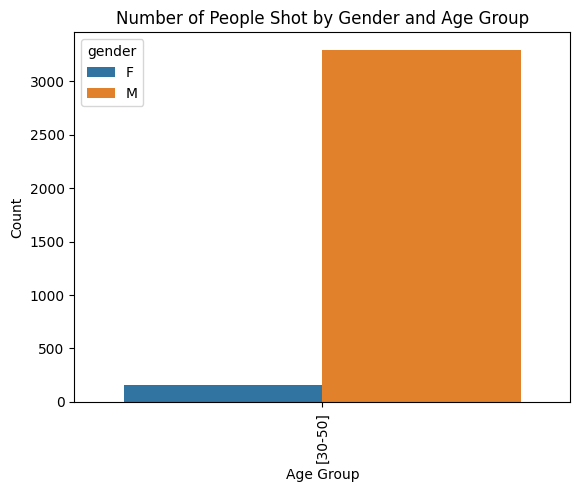

In [23]:
def generate_response_gemini_image(prompt, img):
        response = model_cv.generate_content([prompt, img], stream=True)
        response.resolve()
        return response.text

# To give insights
def understand_image(img):
    prompt = f'''
    Analysis requested: {my_analysis}
    Analysis Output: {analysis_output}
    Data: {data.columns}

    The given image is extracted from the analysis. It is a type of visualisation. 
    If visualization: 
        1. Identify the type of visualization
        2. If labels or legends are present then using them, extract important and accurate insights with numerical figures or percentages from the visualization if there are any.
        3. The insights should be accurate and actionable and related to the analysis mentioned.
    
    Instructions:
    1. Make sure above conditions are met.
    2. Do not include anything else in your response.
    3. Be concise, crisp and concrete.
    4. Refer output analysis to generate actionable insights based on the analysis asked and give business related suggestion if asked.
    '''
    return generate_response_gemini_image(prompt, img)

# Code to generate charts
if insight_choice=='Visualization':
    count, temperature = 0, 0.1
    while count<2:
        try:
            visualization_prompt = f'''
            Information - 
            Task: {my_analysis}
            Output: {analysis_output}

            Types of charts:
            1. Line Chart: Good for trends over time/categories, bad for many data points or complex relationships.
            2. Bar Chart: Compares categories/frequencies, avoid for many categories or negative values.
            3. Scatter Plot: Explores relationships between two variables, not ideal for more than 3 variables or unclear patterns.
            4. Pie Chart: Shows proportions of a whole, avoid for many categories or unclear comparisons.
            5. Histogram: Visualizes distribution of continuous data, not for categorical data.
            6. Box Plot: Compares distributions across categories, avoid if outliers dominate.
            7. Heatmap: Good for visualizing relationships between many variables, bad for complex data, overwhelming for large datasets
            8. Word clouds: good for visual exploration of frequent terms in text data, bad for in-depth analysis.

            Follow the instructions by all means.
            Instructions -
            0. Based on the information available above identify which type of chart would suit the best to convey the insights.
            1. Write code in python to perform an insightful visualization from the output shared above. Don't write any other text. Just code.
            2. Make a new dataframe which has the following data: {analysis_output} and columns: {data.columns} from 'analysis_result.csv'
            3. Don't generate your own data.
            4. Visualization should have title, axis labels, legend etc.
            5. Save the visualization with the name 'viz.png'
            6. Always show x axis labels with a rotation of 90 degrees
            7. If the chart can be built using Seaborn or Plotly then use it all costs
            8. If the column/feature has been encoded then from {code_transcript} extract the origial values of the encoded column to show in the visualization.
            '''
            if count==0:
                vis_code = generate_response(visualization_prompt, temperature, safety_setting)
            vis_code = vis_code.replace('python', '')
            vis_code = vis_code.replace('`', '')
            exec(vis_code)
            break
        except Exception as e:
            error_message = f'''
                Code:
                {vis_code}
                Traceback of the code: {traceback.format_exc()}

                Adhere to below instructions at all costs!
                Instruction:
                1. Identify the cause of the error and rewrite the code - make it error free
                2. Don't include any text in your response
                3. Rewrite the code as a function
                4. Follow these instructions by all means
                '''
            temperature += 0.2
            vis_code = generate_response(error_message, 0.3, safety_setting)
        count+=1
    
    code_transcript+=vis_code+'\n-----------------------------------------\n'

    model_cv = genai.GenerativeModel('gemini-pro-vision')
    img = Image.open('viz.png')
    viz_insight = understand_image(img)
    print(viz_insight)

In [24]:
if insight_choice=='Text':
    textual_insight = f'''
                        Action: Read the analysis output of {my_analysis} carefully: {analysis_output}

                        Instructions:
                        1. Share the results and give concrete and crisp actionable or interesting insights from it.
                        2. Tone: Professional
                        3. Talk always in terms of numbers/figures or percentages'''

    insights = generate_response(textual_insight, 0.5, safety_setting)
    print(insights)

In [25]:
print('Execution Time: (in mins)',(time.time()-start)/60)

Execution Time: (in mins) 1.7349797328313192
